# PWM-G2A Pipeline
This notebook will walk you through how to reproduce our results for a single TF and pair of genomic assays. In our final submission, you will see every motif is assigned an ID as `TF`-`train_assay`-`test_assay`. For example, motif `CAMTA1_CHS_GHTS` was obtained by performing ZMotif and STREME on `CHS` data, and ranking the subsequent pool of motifs by their predictive performance on `GHTS` data. 

In [1]:
! cat ../Results/PWM-G2A-Final/PWM-G2A-Final.txt | head

>CAMTA1 CAMTA1_CHS_CHS
0.07338 0.50461 0.29849 0.12352
0.67319 0.00008 0.24455 0.08219
0.07887 0.86352 0.02106 0.03655
0.00996 0.00918 0.00145 0.97940
0.02526 0.00008 0.97462 0.00004
0.01493 0.95931 0.01166 0.01410
0.28685 0.01019 0.70293 0.00004
0.04565 0.08868 0.77604 0.08963
0.22671 0.60066 0.07657 0.09606


You can set these three variables below as `TF`, `assay` and `test_assay`. As this notebook is a result of pasting 3 notebooks together, you will note that variable names are overwritten and helper functions are scattered throughout. I did not attempt to refactor so as not to risk breaking the pipeline. The snakemake workflow executes the pipeline below using 2 different hyper-parameters, the number of convolution kernels (1 or 16) and the types of peaks to use as input (shared or all; although this feature was removed for GHTS as there are no shared peaks for GHTS data for some TFs). I have hard-coded the use of 16 kernels as a single replicate of 1 kernel may not find the motif of the ChIP'ed TF. I have also set the model to train for 100 epochs, as opposed to the 1000 used by the snakemake pipeline. 100 should be plenty and I've verified it for a handful of TFs. The peak processing method however makes the largest difference in the output motif so I have added to the final plots which method was used to generate the submitted motif. For example, all 4 of the CAMTA1 motifs were obtained with `shared` peaks while the LEUTX motifs were obtaibed with `all` peaks. The 4 rows correspond the pair of `train_assay` and `test_assay`
1. Train: CHS; Test CHS
2. Train: CHS; Test GHTS
3. Train: GHTS; Test: CHS
4. Train: GHTS; Test: GHTS

![title](../Results/PWM-G2A-Final/PWM-G2A-Final.png)

In [2]:
import tensorflow as tf

In [3]:
# verify tensorflow 1.15
tf.__version__

'1.15.0'

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
import numpy as np
from tensorflow.keras import initializers
from tensorflow.keras.layers import Input, Lambda, Conv1D, maximum, GlobalMaxPooling1D, Dense, GaussianNoise, MaxPooling1D, Flatten, BatchNormalization, SpatialDropout1D
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import non_neg
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from  tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence

import matplotlib.pyplot as plt
import pandas as pd
import logomaker

import random
from tqdm import trange
from subprocess import Popen, PIPE, run
import sys
import pickle
from pyfaidx import Fasta
import random
import glob
import bioframe
import os
import tqdm
from multiprocessing import Pool
from sklearn.metrics import roc_auc_score, roc_curve

In [6]:
def getFasta(bf, genomeFasta):
    genome = Fasta(genomeFasta, as_raw=True, sequence_always_upper=True)
    if "strand" in  bf:
        bf.loc[:, "seq"] = [genome[chrom][start:end] if strand == "+" else get_rc(genome[chrom][start:end]) for chrom, start, end, strand in zip(bf.chrom, bf.start, bf.end, bf.strand)]
    else:
        bf.loc[:,"seq"] = [genome[chrom][start:end] for chrom, start, end in zip(bf.chrom, bf.start, bf.end)]
    return(bf)

def load_peaks(peaks, l=None):
    data = pd.read_csv(peaks, header=0, sep="\t", skipfooter=1, engine="python")
    data = data.rename(columns = {"#CHROM" : "chrom", 
                                  "START" : "start", 
                                  "END" : "end", 
                                  "fold_enrichment" : "signal",
                                  " supporting_peakcallers" : "peak_callers"})
    data["n_peak_callers"] = data.peak_callers.str.count(",") + 1
    if l is not None:
        w2 = l // 2
        data["start"] = data["abs_summit"] - w2
        data["end"] = data["abs_summit"] + w2
    return(data)

def merge_peaks(peaks_dfs, l=200):
    w2 = l // 2
    toReturn = peaks_dfs[0].copy()
    for i in range(1, len(peaks_dfs)):
        toReturn = bioframe.closest(toReturn, peaks_dfs[i], 
                               suffixes=('_1','_2'))
        toReturn = toReturn[toReturn["distance"] == 0]
        toReturn["abs_summit_1"] = (i * toReturn["abs_summit_1"] + toReturn["abs_summit_2"]) // (i+1)
        toReturn["signal_1"] = (i * toReturn["signal_1"] + toReturn["signal_2"]) / (i+1)
        toReturn = toReturn.rename(columns = {"chrom_1" : "chrom", 
                                              "start_1" : "start", 
                                              "end_1" : "end", 
                                              "signal_1" : "signal",
                                              "abs_summit_1" : "abs_summit"})
    toReturn["start"] = toReturn["abs_summit"] - w2
    toReturn["end"] = toReturn["abs_summit"] + w2
    
    return(toReturn)



def get_data(TF, assay, data_dir, peaks="all", l=300):
    if assay == "CHS":
        dataFiles = glob.glob(data_dir + assay + "/" + TF + "/*" )
        CHS_data = [load_peaks(_, l) for _ in dataFiles]
        if peaks == "shared" and len(CHS_data) > 1:
            print("Merging peaks")
            CHS_data = merge_peaks(CHS_data, l=l)
        else:
            CHS_data = pd.concat(CHS_data)

        data = CHS_data[["chrom", "start", "end", "abs_summit", "signal"]]
    else:
        GHTS = glob.glob(data_dir + "GHTS" + "/" + TF + "/*" )
        cycles = sorted([os.path.basename(_).split(".")[-2] for _ in GHTS])
        max_cycle = cycles[-1]
        print("Last cycle: {}".format(max_cycle))
        GHTS = [_ for _ in GHTS if "." + max_cycle + "." in _]
        GHTS_data = [load_peaks(_, l) for _ in GHTS]
        # if peaks == "shared":
        #     GHTS_data = merge_peaks(GHTS_data, l=l)
        # else:
        GHTS_data = pd.concat(GHTS_data)
        data = GHTS_data[["chrom", "start", "end", "abs_summit", "signal"]]
    
    data = data.sort_values(['chrom', 'start'], ascending=[True, True]).reset_index(drop=True)
    data = getFasta(data, genomeFasta)
    return(data)


In [7]:
# altschulEriksonDinuclShuffle.py
# P. Clote, Oct 2003

def computeCountAndLists(s):

    #Initialize lists and mono- and dinucleotide dictionaries
    List = {} #List is a dictionary of lists
    List['A'] = []; List['C'] = [];
    List['G'] = []; List['T'] = [];
    # FIXME: is this ok?
    List['N'] = []
    nuclList   = ["A","C","G","T","N"]
    s       = s.upper()
    #s       = s.replace("U","T")
    nuclCnt    = {}  #empty dictionary
    dinuclCnt  = {}  #empty dictionary
    for x in nuclList:
        nuclCnt[x]=0
        dinuclCnt[x]={}
        for y in nuclList:
            dinuclCnt[x][y]=0

    #Compute count and lists
    nuclCnt[s[0]] = 1
    nuclTotal     = 1
    dinuclTotal   = 0
    for i in range(len(s)-1):
        x = s[i]; y = s[i+1]
        List[x].append( y )
        nuclCnt[y] += 1; nuclTotal  += 1
        dinuclCnt[x][y] += 1; dinuclTotal += 1
    assert (nuclTotal==len(s))
    assert (dinuclTotal==len(s)-1)
    return nuclCnt,dinuclCnt,List


def chooseEdge(x,dinuclCnt):
    z = random.random()
    denom=dinuclCnt[x]['A']+dinuclCnt[x]['C']+dinuclCnt[x]['G']+dinuclCnt[x]['T']+dinuclCnt[x]['N']
    numerator = dinuclCnt[x]['A']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['A'] -= 1
        return 'A'
    numerator += dinuclCnt[x]['C']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['C'] -= 1
        return 'C'
    numerator += dinuclCnt[x]['G']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['G'] -= 1
        return 'G'
    numerator += dinuclCnt[x]['T']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['T'] -= 1
        return 'T'
    dinuclCnt[x]['N'] -= 1
    return 'N'

def connectedToLast(edgeList,nuclList,lastCh):
    D = {}
    for x in nuclList: D[x]=0
    for edge in edgeList:
        a = edge[0]; b = edge[1]
        if b==lastCh: D[a]=1
    for i in range(3):
        for edge in edgeList:
            a = edge[0]; b = edge[1]
            if D[b]==1: D[a]=1
    ok = 0
    for x in nuclList:
        if x!=lastCh and D[x]==0: return 0
    return 1

def eulerian(s):
    nuclCnt,dinuclCnt,List = computeCountAndLists(s)
    #compute nucleotides appearing in s
    nuclList = []
    for x in ["A","C","G","T","N"]:
        if x in s: nuclList.append(x)
    #create dinucleotide shuffle L
    firstCh = s[0]  #start with first letter of s
    lastCh  = s[-1]
    edgeList = []
    for x in nuclList:
        if x!= lastCh: edgeList.append( [x,chooseEdge(x,dinuclCnt)] )
    ok = connectedToLast(edgeList,nuclList,lastCh)
    return ok,edgeList,nuclList,lastCh


def shuffleEdgeList(L):
    n = len(L); barrier = n
    for i in range(n-1):
        z = int(random.random() * barrier)
        tmp = L[z]
        L[z]= L[barrier-1]
        L[barrier-1] = tmp
        barrier -= 1
    return L

def dinuclShuffle(s):
    ok = 0
    while not ok:
        ok,edgeList,nuclList,lastCh = eulerian(s)
    nuclCnt,dinuclCnt,List = computeCountAndLists(s)

    #remove last edges from each vertex list, shuffle, then add back
    #the removed edges at end of vertex lists.
    for [x,y] in edgeList: List[x].remove(y)
    for x in nuclList: shuffleEdgeList(List[x])
    for [x,y] in edgeList: List[x].append(y)

    #construct the eulerian path
    L = [s[0]]; prevCh = s[0]
    for i in range(len(s)-2):
        ch = List[prevCh][0]
        L.append( ch )
        del List[prevCh][0]
        prevCh = ch
    L.append(s[-1])
    #t = string.join(L,"")
    t = "".join(L)
    return t

def get_rc(re):
    """
    Return the reverse complement of a DNA/RNA RE.
    """
    return re.translate(str.maketrans('ACGTURYKMBVDHSWN', 'TGCAAYRMKVBHDSWN'))[::-1]



# enriched kmer finding code from https://github.com/daquang/YAMDA
def count_seqs_with_words(seqs, halflength, ming, maxg, alpha, revcomp, desc):
    if alpha == 'protein':
        ambiguous_character = 'X'
    else:
        ambiguous_character = 'N'
    gapped_kmer_dict = {}  # each key is the gapped k-mer word
    for g in trange(ming, maxg + 1, 1, desc=desc):
        w = g+2*halflength # length of the word
        gap = g * ambiguous_character
        for seq in seqs:
            slen = len(seq)
            for i in range(0, slen-w+1):
                word = seq[i : i+w]
                # skip word if it contains an ambiguous character
                if ambiguous_character in word:
                    continue
                # convert word to a gapped word. Only the first and last half-length letters are preserved
                word = word[0:halflength] + gap + word[-halflength:]
                update_gapped_kmer_dict(gapped_kmer_dict, word, revcomp)
    return gapped_kmer_dict


def update_gapped_kmer_dict(gapped_kmer_dict, word, revcomp):
    # use the lower alphabet word for rc
    if revcomp:
        word = min(word, get_rc(word))
    if word in gapped_kmer_dict:  # word has been encountered before, add 1
        gapped_kmer_dict[word] += 1
    else:  # word has not been encountered before, create new key
        gapped_kmer_dict[word] = 1


def get_zscores(pos_seq_counts, neg_seq_counts):
    zscores_dict = {}
    for word in pos_seq_counts:
        p = pos_seq_counts[word]
        if word in neg_seq_counts:
            n = neg_seq_counts[word]
        else:
            n = 1
        zscore = 1.0*(p - n)/np.sqrt(n)
        zscores_dict[word] = zscore
    return zscores_dict


# returns the words in order, from largest to smallest, by z-scores
def sorted_zscore_keys(zscores_dict):
    sorted_keys = sorted(zscores_dict, key=zscores_dict.__getitem__, reverse=True)
    return sorted_keys


def find_n_top_words(zscores_dict, num_find):
    keys = np.array(list(zscores_dict.keys()))
    values = np.array(list(zscores_dict.values()))
    ind = np.argpartition(values, -num_find)[-num_find:]
    top_words = list(keys[ind])
    return top_words


def find_enriched_gapped_kmers(pos_seqs, neg_seqs, halflength, ming, maxg, alpha, revcomp, num_find):
    pos_seq_counts = count_seqs_with_words(pos_seqs, halflength, ming, maxg, alpha, revcomp,
                                           'Searching positive sequences')
    neg_seq_counts = count_seqs_with_words(neg_seqs, halflength, ming, maxg, alpha, revcomp,
                                           'Searching negative sequences')
    zscores = get_zscores(pos_seq_counts,neg_seq_counts)
    top_words = find_n_top_words(zscores, num_find)
    return top_words

DNA_SEQ_DICT = {
    'A' : [1, 0, 0, 0],
    'C' : [0, 1, 0, 0],
    'G' : [0, 0, 1, 0],
    'T' : [0, 0, 0, 1],
}

def encode_sequence(seq, N = [0, 0, 0, 0], seq_dict = None, useN = None):
    if seq_dict is None:
        seq_dict = DNA_SEQ_DICT
    if useN == 'uniform':
        N = [(1/len(seq_dict)) for _ in seq_dict]
    elif useN == 'zeros':
        N = [0 for _ in seq_dict]
    d = { **seq_dict, 'N' : N }
    return np.array([d[nuc] for nuc in list(seq)]).astype('float32')
 
def decode_sequence(encoded_seq, seq_dict = None):
    if seq_dict is None:
        seq_dict = DNA_SEQ_DICT
    seq_list = encoded_seq.astype('int').tolist()
    def decode_base(encoded_base):
        for letter,onehot in seq_dict.items():
            if np.array_equal(encoded_base, onehot):
                return letter
        return "N"
    return "".join(decode_base(b) for b in encoded_seq.astype('int'))

def get_information_content(x):
    ic = x * np.log2((x + .001) / .25)
    if ic > 0:
        return(ic)
    else:
        return(0.0)

In [8]:
def shuffle_wrapper(seqs):
    with Pool(4) as p:
        negSeqs = p.map(dinuclShuffle, seqs)
    return(negSeqs)

class dataGen(Sequence):
    def __init__(self, data, 
                 batchSize = 32,
                 l = 300,
                 seqsPerEpoch=20000,
                 padBy = 0,
                 genomeFasta=None,
                 genomeSizes=None,
                 augment_by=0,
                 curriculum=False,
                 weight_seqs = False):
        
        self.data = data
        self.genomeFasta = genomeFasta
        self.genomeSizes = genomeSizes
        self.seqsPerEpoch = seqsPerEpoch
        self.nPosPerEpoch = seqsPerEpoch // 2
        self.nPos = self.data.shape[0]
        self.augment_by = augment_by
        self.curriculum = curriculum
        self.weight_seqs = weight_seqs
        self.l = l
        self.L = self.l +  2 * self.augment_by
        
        self.l2 = self.l // 2
        self.L2 = self.L // 2
        
        if self.nPos < self.nPosPerEpoch:
            self.posData = self.data.sample(n=self.nPosPerEpoch, replace=True).reset_index(drop=True)
        else:
            self.posData = self.data.copy(deep=True)
            
        if self.augment_by > 0:
            self.posData["aug_by"] = np.random.randint(-self.augment_by, self.augment_by, size=self.posData.shape[0])
            self.posData["posSeq"] = self.posData.apply(lambda x: x['seq'][(self.L2 -self.l2 + x["aug_by"]):(self.L2 +self.l2 + x["aug_by"])], axis=1)
        else:
            self.posData["posSeq"] = self.posData.apply(lambda x: x['seq'][(self.L2 -self.l2):(self.L2 +self.l2)], axis=1)
        self.posData["negSeq"] = shuffle_wrapper(self.posData.posSeq)
        
        if self.curriculum:
            print("Sorting sequences by signal")
            self.posData = self.posData.sort_values("signal", ascending=False).reset_index(drop=True)
        
        self.batchSize = batchSize
        self.b2 = self.batchSize // 2
        self.padBy = padBy
        self.labels = np.array([1 for i in range(self.b2)] + [0 for i in range(self.b2)])
        self.epoch = 0
        self.nIter = 0
        self.shuffleEvery = int(self.nPos // self.nPosPerEpoch) 
        
        if self.shuffleEvery == 0:
            self.shuffleEvery = 1

                
    def __len__(self):
        return(int(np.floor(self.seqsPerEpoch / self.batchSize)))

    
    def on_epoch_end(self):
        self.epoch += 1
        if (self.epoch % self.shuffleEvery) == 0:
            if self.nPos < self.nPosPerEpoch:
                self.posData = self.data.sample(n=self.nPosPerEpoch, replace=True, weights="signal").reset_index(drop=True)
            else:
                self.posData = self.data.copy(deep=True)
            
            if self.augment_by > 0:
                self.posData["aug_by"] = np.random.randint(-self.augment_by, self.augment_by, size=self.posData.shape[0])
                self.posData["posSeq"] = self.posData.apply(lambda x: x['seq'][(self.L2 -self.l2 + x["aug_by"]):(self.L2 +self.l2 + x["aug_by"])], axis=1)
            else:
                self.posData["posSeq"] = self.posData.apply(lambda x: x['seq'][(self.L2 -self.l2):(self.L2 +self.l2)], axis=1)
            
            if self.curriculum:
                self.posData = self.posData.sort_values("signal", ascending=False).reset_index(drop=True)
                
            self.posData["negSeq"] = shuffle_wrapper(self.posData.posSeq)
            self.nIter = 0

    def __getitem__(self, index):
        X = 0.25 * np.ones((self.batchSize, 2*self.padBy + self.l, 4))
        if self.weight_seqs:
            weights = np.zeros(self.batchSize)
            
        for i, (_, row) in enumerate(self.posData.iloc[(index*self.b2):((index*self.b2) + self.b2)].iterrows()):
            posSeq = row.posSeq
            negSeq = row.negSeq
            X[i,self.padBy:self.l+self.padBy,:] = encode_sequence(posSeq)
            X[i+self.b2,self.padBy:self.l+self.padBy,:] = encode_sequence(negSeq)
            
            if self.weight_seqs:
                weights[i] = np.log2(row.signal + 1)
                weights[i+self.b2] = 1
        if self.weight_seqs:
            return(X, self.labels, weights)
        else:
            return(X, self.labels)

In [9]:
from  tensorflow.keras.callbacks import Callback
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.

    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2,
                 shape="cosine"):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor
        
        self.shape = shape
        self.history = {}
        self.learning_rates = []

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        #print(fraction_to_restart)
        if self.shape == "cosine":
            lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        else:
            if fraction_to_restart < 0.5:
                lr = fraction_to_restart * (self.max_lr - self.min_lr) / 0.5 + self.min_lr
            else:
                lr = (1 - fraction_to_restart) * (self.max_lr - self.min_lr) / 0.5 + self.min_lr
        self.learning_rates.append(lr)
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        if self.shape == "cosine":
            K.set_value(self.model.optimizer.lr, self.max_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.min_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)
        
class SWA(Callback):

    def __init__(self, epochs_to_train, prop = 0.2, interval = 1):
        super(SWA, self).__init__()
        self.epochs_to_train = epochs_to_train
        self.prop = prop
        self.interval = interval
        self.n_models = 0
        self.epoch = 0
        
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        self.weights = []
    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1
        if epoch % self.interval == 0:
            self.weights.append(self.model.get_weights())
            self.n_models += 1
        else:
            pass

    def on_train_end(self, logs=None):
        num_models_to_average = int(np.ceil(self.prop * self.epoch))
        new_weights = list()
        for weights_list_tuple in zip(*self.weights[-num_models_to_average:]): 
            new_weights.append(
                np.array([np.array(w).mean(axis=0) for w in zip(*weights_list_tuple)])
            )
        self.model.set_weights(new_weights)

In [10]:
def construct_model(num_kernels=32,
                    kernel_width=24,
                    seq_len=None,
                    dropout_prop=0.0,
                    use_bias=False,
                    kernel_initializer=initializers.RandomNormal(stddev=0.0001, seed=12),
                    optimizer='adam',
                    activation='linear',
                    num_classes=1,
                    l1_reg=0.0,
                    l2_reg= 0.0,
                    gaussian_noise = 0.0,
                    spatial_dropout = 0.0,
                    rc = True,
                    padding="same",
                    conv_name="shared_conv"):
        
    seq_input = Input(shape=(seq_len,4))
        
    # apply gaussian blurring
    if gaussian_noise > 0.0:
         noisy_seq = GaussianNoise(gaussian_noise)(seq_input)
    
    # apply spatial dropout
    if spatial_dropout > 0.0:
        sd = SpatialDropout1D(spatial_dropout)
        if gaussian_noise > 0.0:
            noisy_seq = sd(noisy_seq)
        else:
            noisy_seq = sd(seq_input)
        
    # perform reverse complement
    rc_op = Lambda(lambda x: K.reverse(x,axes=(1,2)))
    
    seq_rc = rc_op(seq_input)
    if gaussian_noise > 0.0 or spatial_dropout > 0.0:
        noisy_seq_rc = rc_op(noisy_seq)
    else:
        seq_rc = rc_op(seq_input)
        
    # convolution
    shared_conv = Conv1D(num_kernels, kernel_width,
                         strides=1,
                         padding=padding, 
                         activation=activation,
                         use_bias=use_bias,
                         kernel_initializer=kernel_initializer,
                         kernel_regularizer=regularizers.l1_l2(l1=l1_reg,
                                                               l2=l2_reg),
                         bias_initializer='zeros',
                         name=conv_name)
    if gaussian_noise > 0.0 or spatial_dropout > 0.0:
        conv_for = shared_conv(noisy_seq)
        conv_rc = shared_conv(noisy_seq_rc)
    else:
        conv_for = shared_conv(seq_input)
        conv_rc = shared_conv(seq_rc)

    merged = maximum([conv_for, conv_rc])
    pooled = GlobalMaxPooling1D()(merged)
    
    if dropout_prop > 0.0:
        dropout = Dropout(dropout_prop)(pooled)
        output = Dense(1, activation='sigmoid',
                   use_bias=True,
                   kernel_initializer=initializers.RandomUniform(minval=0.0, maxval=0.001, seed=12), 
                   kernel_constraint=non_neg(), 
                   bias_initializer='zeros',
                   name="dense_1")(dropout)
    else:
        output = Dense(1, activation='sigmoid',
                       use_bias=True,
                       kernel_initializer=initializers.RandomUniform(minval=0.0, maxval=0.001, seed=12), 
                       kernel_constraint=non_neg(), 
                       bias_initializer='zeros',
                       name="dense_1")(pooled)
    model = Model(inputs=seq_input, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model



def construct_scan_model(conv_weights):
    kernel_width = conv_weights.shape[0]
    num_kernels = conv_weights.shape[2]
    seq = Input(shape=(None,4))
    conv = Conv1D(num_kernels, kernel_width, 
                  name = 'scan_conv',
                  strides=1, 
                  padding='valid', 
                  activation='linear', 
                  use_bias=False, 
                  kernel_initializer='zeros', 
                  bias_initializer='zeros',
                  trainable=False)
    
    conv_seq = conv(seq)
    
    
    model = Model(inputs=seq, outputs=conv_seq)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.get_layer('scan_conv').set_weights([conv_weights])
    return model

def construct_score_model(conv_weights):
    kernel_width = conv_weights.shape[0]
    num_kernels = conv_weights.shape[2]
    seq = Input(shape=(None,4))
    rc_op = Lambda(lambda x: K.reverse(x,axes=(1,2)))
    seq_rc = rc_op(seq)
    
    conv = Conv1D(num_kernels, kernel_width, 
                  name = 'score_conv',
                  strides=1, 
                  padding='valid', 
                  activation='linear', 
                  use_bias=False, 
                  kernel_initializer='zeros', 
                  bias_initializer='zeros',
                  trainable=False)
    
    conv_for = conv(seq)
    conv_rc = conv(seq_rc)
    
    merged = maximum([conv_for, conv_rc])
    pooled = GlobalMaxPooling1D()(merged)
    model = Model(inputs=seq, outputs=pooled)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.get_layer("score_conv").set_weights([conv_weights])
    print(model.summary())
    return model


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Parameters

In [11]:
TF = "CAMTA1"
assay = "CHS" # or GHTS
test_assay = "CHS" # of GHTS
peaks = "shared" # or shared
n_motifs = 16 # number of motifs / convolution kernels
epochs = 100 # number of epochs to train for, the pipeline uses 1000 but this should be plenty
nCPUs = 4 # streme and CV auROC calculation run parallel

In [12]:
data_dir = "../data/"
genomeFasta = "../data/hg38.fa"
output_dir = "../demo/PWM-G2A"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
weights_file = output_dir + "/weights.h5"
# temporary file to dump motif instances
motifs_bed = output_dir + "/motifs.bed"

# final output file of motifs instances
motifs_file = output_dir + "/motifs.txt.gz"

# streme pkl
outPickle = output_dir + "/STREME.pkl"
# final motif in IBIS format
motif_out = output_dir + "/{}-{}-{}.ibis-formatted.txt".format(TF, assay, test_assay)

In [13]:
seqsPerEpoch = 5000
l = 300
w = 32
aug_by = 100
n_kmers = 4 # if greater than 0, will seed network with that many enriched kmers
if n_kmers > n_motifs:
    n_kmers = n_motifs
L = l + 2*aug_by
l2 = l // 2
L2 = L // 2
genome = Fasta(genomeFasta, as_raw=True, sequence_always_upper=True)
test_chroms = ["chr1"] # chromosomes to hold out
activation = "linear" # or exponential (convolution layer activation)
use_bias = True # include bias term in convolution layer
sd = 0.2 # spatial dropout
gaussian_noise = 0.1
l1 = 1e-5
l2 = 1e-5
curriculum = True
weight_seqs = False
min_lr = .001
max_lr = .1

In [14]:
# will throw a parser warning because the peak files have a header & footer that must be skipped
data = get_data(TF, assay, data_dir, l=L, 
                peaks=peaks)

In [15]:
data.head()

,chrom,start,end,abs_summit,signal,seq
0,chr1,629692,630192,629942,6.30401,CATCACAGCGCTAAGCTCGCACTGATTTTTTACCTGAGTAGGCCTA...
1,chr1,633781,634281,634031,6.80891,ATTGATCCCCACCTCCAAATATCTCATCAACAACCGACTAATTACC...
2,chr1,778506,779006,778756,3.64815,TACCCTTCTTCAGCCGGCAACACACAGAACCTGGCGGGGAGGTCAC...
3,chr1,904513,905013,904763,9.47817,GTGGCCTCCTCCGAACGCGGCCGCCTCCTCCTCCGAACGCGGCCGC...
4,chr1,940167,940667,940417,6.15911,AAATGTTAATAATGTAAAAATCCTCCTTTTTAATTGCTTTCCCTGC...


In [16]:
n = data.shape[0]
print("{} total sequences provided".format(n))

1115 total sequences provided


In [17]:
if n_kmers > 0:
    print("Finding enriched gapped kmers")
    if n > 5000:
        tmpPosSeqs = data.sort_values("signal", ascending=False).head(5000).seq.tolist()
        tmpPosSeqs = [seq[(L2-50):(L2+50)] for seq in tmpPosSeqs]
    else:
        tmpPosSeqs = data.seq.tolist()
        tmpPosSeqs = [seq[(L2-50):(L2+50)] for seq in tmpPosSeqs]
    kmers = find_enriched_gapped_kmers(tmpPosSeqs, [dinuclShuffle(_) for _ in tmpPosSeqs],  3, 0, 18, "dna", False, n_kmers)

Finding enriched gapped kmers


Searching negative sequences: 100%|██████████| 19/19 [00:01<00:00, 18.20it/s]


In [18]:
print("Enriched kmers...\n" + "\n".join(["\t" + _ for _ in kmers[::-1]]))

Enriched kmers...
	ATTNNNNNNNNNNNNATT
	TTCNNNNNNNNNNNATT
	TTCNATT
	CCANNNNNNNNNATT


In [19]:
train_data = data[~data["chrom"].isin(test_chroms)]
test_data = data[data["chrom"].isin(test_chroms)]

In [20]:
train_gen = dataGen(train_data, 
                 batchSize = 32,
                 l = l,
                 seqsPerEpoch=seqsPerEpoch,
                 padBy = w,
                 augment_by=aug_by, 
                    curriculum=curriculum, 
                    weight_seqs=weight_seqs)

test_gen = dataGen(train_data, 
                 batchSize = 32,
                 l = l,
                 seqsPerEpoch=1000,
                 padBy = w,
                 augment_by=0, 
                   curriculum=False, 
                   weight_seqs=False)

Sorting sequences by signal


In [21]:
model = construct_model(num_kernels=n_motifs,
                        kernel_width=w,
                        l1_reg=l1,
                        l2_reg=l2,
                        spatial_dropout=sd,
                        gaussian_noise=gaussian_noise,
                        activation=activation,
                        use_bias=use_bias,
                        padding="valid")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, None, 4)      0           input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, None, 4)      0           gaussian_noise[0][0]             

In [22]:
if n_kmers > 0:
    if use_bias:
        conv_weights, conv_bias = model.get_layer("shared_conv").get_weights()
    else:
        conv_weights = model.get_layer("shared_conv").get_weights()[0]


    for i in range(n_kmers):
        kmer = kmers[i]
        l = len(kmer)
        conv_weights[((w - l)//2):(((w - l)//2)+l),:,i] = encode_sequence(kmer)


    if use_bias:
        model.get_layer("shared_conv").set_weights([conv_weights, conv_bias])
    else:
        model.get_layer("shared_conv").set_weights([conv_weights])


In [23]:
lr_decay = (min_lr / max_lr) ** (1 / epochs)
schedule = SGDRScheduler(min_lr=min_lr,
                             max_lr=max_lr,
                             steps_per_epoch=train_gen.__len__(),
                             lr_decay=lr_decay,
                             cycle_length=1,
                             mult_factor=1.0, 
                             shape="triangular")

swa = SWA(epochs)


In [24]:
history = model.fit(train_gen, 
                    steps_per_epoch = train_gen.__len__(), 
                    verbose=2, 
                    epochs=epochs,
                    workers=1,
                    callbacks = [schedule, swa],
                    validation_data = test_gen,
                    validation_steps = test_gen.__len__(), 
                    shuffle=False)


Epoch 1/100
Epoch 1/100
156/156 - 3s - loss: 0.6724 - acc: 0.6000 - val_loss: 0.7177 - val_acc: 0.5806
Epoch 2/100
Epoch 1/100
156/156 - 3s - loss: 0.6441 - acc: 0.6494 - val_loss: 0.7157 - val_acc: 0.5988
Epoch 3/100
Epoch 1/100
156/156 - 3s - loss: 0.6347 - acc: 0.6707 - val_loss: 0.7613 - val_acc: 0.5877
Epoch 4/100
Epoch 1/100
156/156 - 3s - loss: 0.6064 - acc: 0.6923 - val_loss: 0.8036 - val_acc: 0.5837
Epoch 5/100
Epoch 1/100
156/156 - 3s - loss: 0.6369 - acc: 0.6907 - val_loss: 0.7506 - val_acc: 0.6038
Epoch 6/100
Epoch 1/100
156/156 - 3s - loss: 0.6045 - acc: 0.7139 - val_loss: 0.8600 - val_acc: 0.5575
Epoch 7/100
Epoch 1/100
156/156 - 3s - loss: 0.5951 - acc: 0.7185 - val_loss: 0.8188 - val_acc: 0.5806
Epoch 8/100
Epoch 1/100
156/156 - 3s - loss: 0.5926 - acc: 0.7185 - val_loss: 0.8523 - val_acc: 0.5726
Epoch 9/100
Epoch 1/100
156/156 - 3s - loss: 0.5979 - acc: 0.7179 - val_loss: 0.8719 - val_acc: 0.5655
Epoch 10/100
Epoch 1/100
156/156 - 3s - loss: 0.5724 - acc: 0.7348 - val_

In [25]:
model.save_weights(weights_file)

In [26]:
if use_bias:
    conv_weights, conv_bias = model.get_layer("shared_conv").get_weights()
else:
    conv_weights = model.get_layer("shared_conv").get_weights()[0]


In [27]:
AUCs = {}
nSteps = 200
for i in range(n_motifs):
    tmp_conv_weights = np.zeros(conv_weights.shape)
    if use_bias:
        tmp_bias = np.zeros(n_motifs)
    tmp_conv_weights[:,:,i] = conv_weights[:,:,i]
    
    if use_bias:
        tmp_bias[i] = conv_bias[i]
    
    if use_bias:
        model.get_layer("shared_conv").set_weights([tmp_conv_weights, tmp_bias])
    else:
        model.get_layer("shared_conv").set_weights([tmp_conv_weights])
    yPred = model.predict(test_gen, steps=nSteps)
    yTest = np.array(nSteps*([1 for i in range(16)] + [0 for i in range(16)]))
    AUCs[i] = roc_auc_score(yTest, yPred)

In [28]:
scan_model = construct_scan_model(conv_weights)

In [29]:
anr = False # nomenclature taken from meme
thresh = 0
with open(motifs_bed, "w") as f:
    for i in trange(data.shape[0], disable=False):
        chrom, start, stop = data.iloc[i][:3]
        start, stop = int(start), int(stop)
        seq = genome[chrom][start:stop]
        
        encoded_seq = np.vstack((0.25*np.ones((w,4)), encode_sequence(seq), 0.25*np.ones((w,4))))
        encoded_seq_rc = encoded_seq[::-1,::-1]

        conv_for = scan_model.predict(np.expand_dims(encoded_seq, axis = 0), verbose=0)[0]
        conv_rc = scan_model.predict(np.expand_dims(encoded_seq_rc, axis = 0), verbose=0)[0]

        for k in range(n_motifs):
            if anr:
                matches_for = np.argwhere(conv_for[:,k] > thresh)[:,0].tolist()
                matches_rc = np.argwhere(conv_rc[:,k] > thresh)[:,0].tolist()
                for x in matches_for:
                    motif_start = x - w
                    motif_end = motif_start + w
                    score = conv_for[x,k]
                    motifSeq = decode_sequence(encoded_seq[x:x+w,:])
                    print(chrom, start+motif_start, start+motif_end, k, score, "+", motifSeq, file=f, sep="\t")

                for x in matches_rc:
                    motif_end = x + w
                    motif_start = motif_end - w 
                    score = conv_rc[x,k] 
                    motifSeq = decode_sequence(encoded_seq_rc[x:x+w,:])
                    print(chrom, stop-motif_start, stop-motif_start+w, k, score, "-", motifSeq, file=f, sep="\t")
                
            else:
                maxFor = np.max(conv_for[:,k])
                maxRC = np.max(conv_rc[:,k])

                if maxFor > thresh or maxRC > thresh:
                    if maxFor > maxRC:
                        x = np.argmax(conv_for[:,k])
                        motif_start = x - w
                        motif_end = motif_start + w
                        score = conv_for[x,k]
                        motifSeq = decode_sequence(encoded_seq[x:x+w,:])
                        print(chrom, start+motif_start, start+motif_end, k, score, "+", motifSeq, file=f, sep="\t")
                    else:
                        x = np.argmax(conv_rc[:,k])
                        motif_end = x + w
                        motif_start = motif_end - w 
                        score = conv_rc[x,k] 
                        motifSeq = decode_sequence(encoded_seq_rc[x:x+w,:])
                        print(chrom, stop-motif_start, stop-motif_start+w, k, score, "-", motifSeq, file=f, sep="\t")

100%|██████████| 1115/1115 [00:12<00:00, 92.15it/s]


In [30]:
motifs = pd.read_csv(motifs_bed, sep="\t", names=["chrom", "start", "end", "kernel", "score", "strand", "seq"])
data["start"] = data.start.astype(int)
data["end"] = data.end.astype(int)

df = bioframe.closest(motifs, data, suffixes=('_motif','_peak'))


df = df.sort_values(['chrom_motif', 'start_motif'], ascending=[True, True]).reset_index(drop=True)
df = df.rename(columns = {"chrom_motif" : "chrom", 
                      "start_motif" : "start",
                      "end_motif" : "end", 
                      "kernel_motif" : "kernel", 
                      "score_motif" : "score",
                      "strand_motif" : "strand", 
                        "seq_motif" : "seq",
                      "p_peak" : "p", 
                      "signal_peak" : "signal"})

In [31]:
df.head()

,chrom,start,end,kernel,score,strand,seq,chrom_peak,start_peak,end_peak,abs_summit_peak,signal,seq_peak,distance
0,chr1,629706,629738,13,5.654951,+,GCTCGCACTGATTTTTTACCTGAGTAGGCCTA,chr1,629692,630192,629942,6.30401,CATCACAGCGCTAAGCTCGCACTGATTTTTTACCTGAGTAGGCCTA...,0
1,chr1,629739,629771,1,6.582921,+,AAATAAACATGCTAGCTTTTATTCCAGTTCTA,chr1,629692,630192,629942,6.30401,CATCACAGCGCTAAGCTCGCACTGATTTTTTACCTGAGTAGGCCTA...,0
2,chr1,629755,629787,12,7.647026,-,GGTTTATTTTTTTGGTTAGAACTGGAATAAAA,chr1,629692,630192,629942,6.30401,CATCACAGCGCTAAGCTCGCACTGATTTTTTACCTGAGTAGGCCTA...,0
3,chr1,629781,629813,14,2.865434,-,CTTGATGGCAGCTTCTGTGGAACGAGGGTTTA,chr1,629692,630192,629942,6.30401,CATCACAGCGCTAAGCTCGCACTGATTTTTTACCTGAGTAGGCCTA...,0
4,chr1,629788,629820,15,4.164781,-,GGAAATACTTGATGGCAGCTTCTGTGGAACGA,chr1,629692,630192,629942,6.30401,CATCACAGCGCTAAGCTCGCACTGATTTTTTACCTGAGTAGGCCTA...,0


In [32]:
df = df.drop_duplicates().reset_index(drop=True)
df["start"] = df["start"] - 4
df["end"] = df["end"] + 4
df = getFasta(df, genomeFasta)
df["auc"] = df.kernel.map(AUCs)
df.to_csv(motifs_file, index=False, sep="\t")

In [33]:
df.head()

,chrom,start,end,kernel,score,strand,seq,chrom_peak,start_peak,end_peak,abs_summit_peak,signal,seq_peak,distance,auc
0,chr1,629702,629742,13,5.654951,+,CTAAGCTCGCACTGATTTTTTACCTGAGTAGGCCTAGAAA,chr1,629692,630192,629942,6.30401,CATCACAGCGCTAAGCTCGCACTGATTTTTTACCTGAGTAGGCCTA...,0,0.664254
1,chr1,629735,629775,1,6.582921,+,CTAGAAATAAACATGCTAGCTTTTATTCCAGTTCTAACCA,chr1,629692,630192,629942,6.30401,CATCACAGCGCTAAGCTCGCACTGATTTTTTACCTGAGTAGGCCTA...,0,0.629103
2,chr1,629751,629791,12,7.647026,-,CGAGGGTTTATTTTTTTGGTTAGAACTGGAATAAAAGCTA,chr1,629692,630192,629942,6.30401,CATCACAGCGCTAAGCTCGCACTGATTTTTTACCTGAGTAGGCCTA...,0,0.606310
3,chr1,629777,629817,14,2.865434,-,AATACTTGATGGCAGCTTCTGTGGAACGAGGGTTTATTTT,chr1,629692,630192,629942,6.30401,CATCACAGCGCTAAGCTCGCACTGATTTTTTACCTGAGTAGGCCTA...,0,0.676336
4,chr1,629784,629824,15,4.164781,-,GTGAGGAAATACTTGATGGCAGCTTCTGTGGAACGAGGGT,chr1,629692,630192,629942,6.30401,CATCACAGCGCTAAGCTCGCACTGATTTTTTACCTGAGTAGGCCTA...,0,0.642851


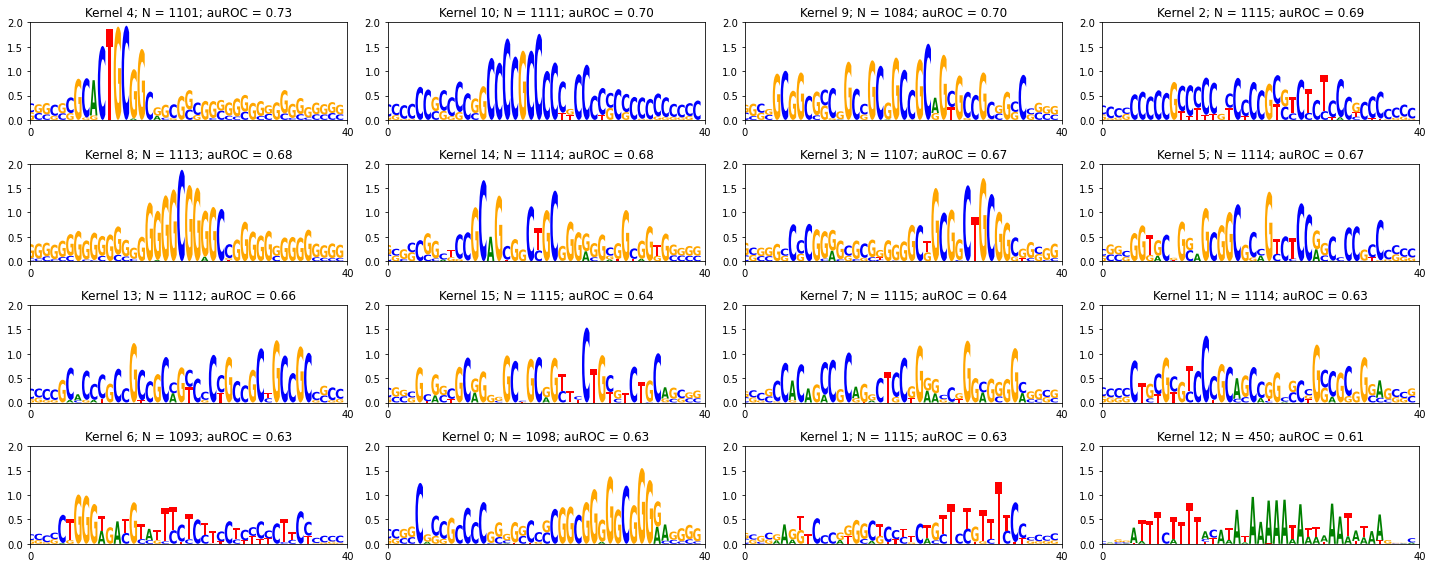

In [34]:
fig, axes = plt.subplots(4,4, figsize=(20,8), tight_layout=True)
for plot_i, i in enumerate(np.argsort(list(AUCs.values()))[::-1]):
    n = df[df["kernel"] == i].shape[0]
    auc = AUCs[i]
    ax = axes.flatten()[plot_i]
    ppm = logomaker.alignment_to_matrix(df[df["kernel"] == i].seq, to_type="counts")
    ppm = ppm[["A", "C", "G", "T"]]
    ppm = ppm.div(ppm.sum(axis=1), axis=0)
    logomaker.Logo(ppm.applymap(get_information_content), ax=ax)
    ax.set_ylim([0,2])
    ax.set_xlim([0, w+8])
    ax.set_xticks([0, w+8])
    ax.set_title("Kernel {0}; N = {1}; auROC = {2:.2f}".format(i, n, auc))
for i in range(n_motifs, 16):
    fig.delaxes(axes.flatten()[i])

## STREME

In [35]:
import subprocess
import itertools

In [36]:
def motif_to_fasta(bf, kernel, outFasta):
    tmp_df = df[df["kernel"] == kernel].reset_index()
    with open(outFasta, "w") as f:
        for i, row in tmp_df.iterrows():
            chrom, start, end, seq = row.chrom, row.start, row.end, row.seq
            print(">{}:{}-{}".format(chrom, start, end), file=f)
            print(seq, file=f)

def parse_streme_out(streme_out):
    with open(streme_out) as f:
        lines = [line.strip().split() for line in f.readlines()]
    lines = [line for line in lines if len(line) > 0]
    lines = [line for line in lines if line[0].replace(".","").isdigit()]
    ppm = np.array(lines, dtype=float)
    return(ppm)


In [37]:
WIDTHS = [None,8,10,12,14,16,18,24,30]
nCPUs = 4

In [38]:
motifs_to_refine = [max(AUCs, key=AUCs.get)]
og_ppm = logomaker.alignment_to_matrix(df[df["kernel"] == motifs_to_refine[0]].seq, to_type="counts")
og_ppm = og_ppm[["A", "C", "G", "T"]]
og_ppm = og_ppm.div(og_ppm.sum(axis=1), axis=0)

In [39]:
for k in motifs_to_refine:
    motif_to_fasta(df, k, output_dir + "/{}.tmp.fa".format(k))

In [40]:
streme_cmds = []
for k in motifs_to_refine:
    for w in WIDTHS:
        if w is None:
            cmd = "streme --nmotifs 1 --order 2 --text -p {0}/{1}.tmp.fa > {0}/{1}-{2}.streme.out 2> {0}/{1}-{2}.streme.err".format(output_dir, k, "None")
        else:
            cmd = "streme --nmotifs 1 --order 2 --text -w {2} -p {0}/{1}.tmp.fa > {0}/{1}-{2}.streme.out 2> {0}/{1}-{2}.streme.err".format(output_dir, k, w)
        streme_cmds.append(cmd)

In [41]:
def run(cmd):
    subprocess.run(cmd, shell=True)

In [42]:
with Pool(nCPUs) as p:
    p.map(run, streme_cmds)

In [43]:
PPMs = {}
for k, w in itertools.product(motifs_to_refine, WIDTHS):
    streme_out = output_dir + "/{}-{}.streme.out".format(k,w)
    ppm = parse_streme_out(streme_out)
    PPMs[str(k) + "-" + str(w)] = ppm

In [44]:
with open(outPickle, "wb") as f:
    pickle.dump(PPMs, f)

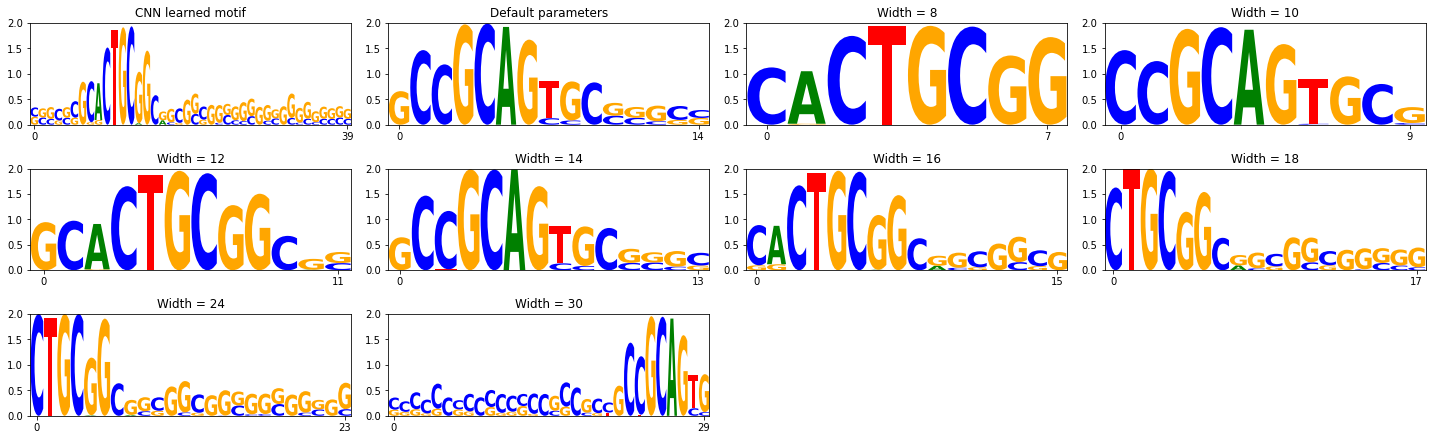

In [45]:
fig, axes = plt.subplots(4,4, figsize=(20,8), tight_layout=True)
    
#plot original ppm
ax = axes.flatten()[0]
w = og_ppm.shape[0]
logomaker.Logo(og_ppm.applymap(get_information_content), ax=ax)
ax.set_ylim([0,2])
ax.set_xlim([0-0.5, w-0.5])
ax.set_xticks([0, w-1])
ax.set_title("CNN learned motif")
for i, (width, ppm) in enumerate(zip(WIDTHS, list(PPMs.values()))):
    ax = axes.flatten()[i+1]
    ppm = pd.DataFrame(ppm, columns=["A", "C", "G", "T"])
    w = ppm.shape[0]
    logomaker.Logo(ppm.applymap(get_information_content), ax=ax)
    ax.set_ylim([0,2])
    ax.set_xlim([0-0.5, w-0.5])
    ax.set_xticks([0, w-1])
    if width is not None:
        ax.set_title("Width = {}".format(width))
    else:
        ax.set_title("Default parameters")

for i in range(len(PPMs)+1, 16):
    fig.delaxes(axes.flatten()[i])

## CV

In [46]:
def flatten(xss):
    return [x for xs in xss for x in xs]

def ppm_to_pwm(ppm):
    pwm = ppm + 1e-5
    pwm = pwm / 0.25
    pwm = np.log2(pwm)
    return(pwm)

def run_imap_multiprocessing(func, argument_list, num_processes):

    pool = Pool(processes=num_processes)

    result_list_tqdm = []
    for result in tqdm.tqdm(pool.imap(func=func, iterable=argument_list), total=len(argument_list)):
        result_list_tqdm.append(result)

    return result_list_tqdm

def get_auroc(x):
    yTest, yPred = x
    return(roc_auc_score(yTest, yPred))

In [47]:
def get_ZMotif_motifs(motifs_file):
    df = pd.read_csv(motifs_file, sep="\t", header=0)
    
    kernels = sorted(df.kernel.unique().tolist())
    AUCs = dict(zip(df.kernel, df.auc))
    kernel = max(AUCs, key=AUCs.get)
    PPMs = []
    tmp_df = df[df["kernel"] == kernel]
    ppm = logomaker.alignment_to_matrix(tmp_df.seq, to_type="probability")
    ppm = ppm[["A", "C", "G", "T"]]
    w = ppm.shape[0]
    for i in range(w-30+1):
        PPMs.append([motifs_file, ppm.iloc[i:i+30,:]])
    return(PPMs)

def get_STREME_motifs(stremePkl):
    with open(stremePkl, "rb") as f:
        PPMs = pickle.load(f)
    return([[stremePkl + "-" + _, PPMs[_]] for _ in PPMs])

In [48]:
ZMotif_PPMs = get_ZMotif_motifs(motifs_file)
STREME_PPMs = get_STREME_motifs(outPickle)

In [49]:
PPMs = ZMotif_PPMs + STREME_PPMs

In [50]:
genomeFasta = data_dir + "/hg38.fa"
PWMs = [ppm_to_pwm(_[1]) for _ in PPMs]
weights = np.zeros([len(PWMs), 30, 4])
for i, pwm in enumerate(PWMs):
    w = pwm.shape[0]
    if w > 0:
        start = (30 - w) // 2
        stop = start + pwm.shape[0]
        weights[i,start:stop,:] = pwm
weights = np.moveaxis(weights,0,-1)
model = construct_score_model(weights)
aug_by = 0
if test_assay == "GHTS":
    l = 100
else:
    l = 300

nNegs = 1
data = get_data(TF, test_assay, data_dir,
                peaks="all", l=l)
min_n = 20000
data = data.sample(n=min_n, replace=True, weights="signal")
if aug_by > 0:
    aug = np.random.randint(-aug_by, aug_by, size=data.shape[0])
    data.loc[:,"start"] = data["start"] + aug
    data.loc[:,"end"] = data["end"] + aug
data = data.sort_values(['chrom', 'start'], ascending=[True, True]).reset_index(drop=True)
data = getFasta(data, genomeFasta)

Xpos = np.array([encode_sequence(seq) for seq in data.seq])
negSeqs = []
for seq in data.seq:
    for i in range(nNegs):
        negSeqs.append(dinuclShuffle(seq))

Xneg = np.array([encode_sequence(seq) for seq in negSeqs])
yTest = np.array([1 for _ in range(Xpos.shape[0])] + [0 for _ in range(Xneg.shape[0])])
X = np.vstack([Xpos, Xneg])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 4)      0           input_3[0][0]                    
__________________________________________________________________________________________________
score_conv (Conv1D)             (None, None, 20)     2400        input_3[0][0]                    
                                                                 lambda_1[0][0]                   
__________________________________________________________________________________________________
maximum_1 (Maximum)             (None, None, 20)     0           score_conv[0][0]           

In [51]:
print("Scoring sequences with PWMs")
scores = model.predict(X, verbose=1)
print("Calculating auROCs")
AUCs = run_imap_multiprocessing(get_auroc, [[yTest, scores[:,i]] for i in range(len(PWMs))], nCPUs)

Scoring sequences with PWMs
40000/40000 [==============================] - 1s 28us/sample
Calculating auROCs


100%|██████████| 20/20 [00:00<00:00, 285.92it/s]


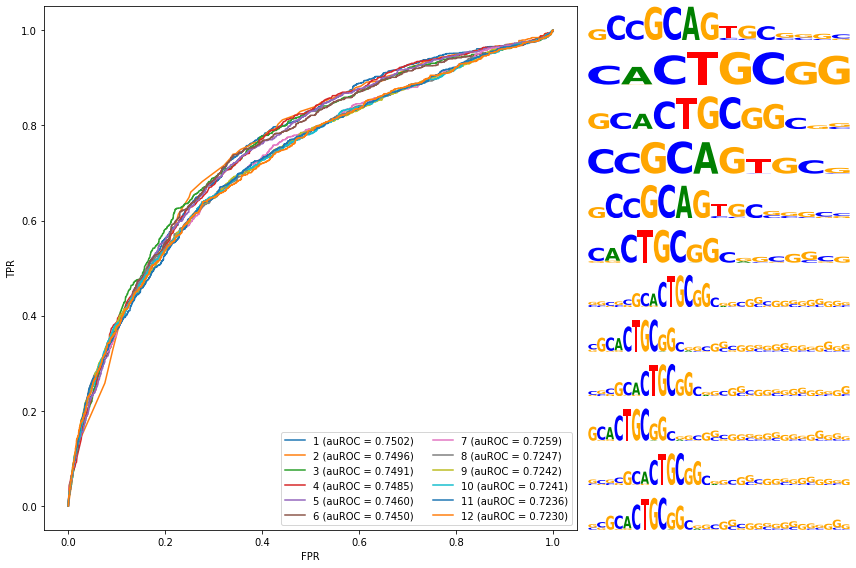

In [52]:
fig = plt.figure(figsize=(12,8), tight_layout=True)
gs = fig.add_gridspec(12, 12)
ax1 = fig.add_subplot(gs[:, :8])
logo_axes = [fig.add_subplot(gs[i, 8:]) for i in range(12)]
for plot_i, i in enumerate(np.argsort(AUCs)[::-1][:12]):
    fpr, tpr, r = roc_curve(yTest, scores[:,i])
    auROC = roc_auc_score(yTest, scores[:,i])
    ax1.plot(fpr, tpr, label="{0} (auROC = {1:.4f})".format(plot_i+1, auROC))
    ax1.set_xlabel("FPR")
    ax1.set_ylabel("TPR")
    ppm = PPMs[i][1]
    ppm = pd.DataFrame(ppm, columns=["A", "C", "G", "T"]).reset_index(drop=True)
    logomaker.Logo(ppm.applymap(get_information_content), ax=logo_axes[plot_i])
    logo_axes[plot_i].axis("off")
    logo_axes[plot_i].set_ylim([0,2])
    #logo_axes[plot_i].set_title(plot_i+1)
ax1.legend(loc='lower right', ncol=2)

In [53]:
ppm = pd.DataFrame(PPMs[np.argmax(AUCs)][1], columns=["A", "C", "G", "T"])
with open(motif_out, "w") as f:
    print(">{0} {0}_{1}_{2}".format(TF, assay, test_assay), file=f)
    for i in range(ppm.shape[0]):
        print(" ".join(["%.5f" % v for v in ppm.values[i,:]]), file=f)

In [54]:
motif_out

'../demo/PWM-G2A/CAMTA1-CHS-CHS.ibis-formatted.txt'

In [55]:
!cat {motif_out}

>CAMTA1 CAMTA1_CHS_CHS
0.05483 0.19407 0.55815 0.19295
0.02780 0.83904 0.11673 0.01644
0.00003 0.73605 0.00259 0.26134
0.00003 0.00511 0.99483 0.00003
0.00255 0.99357 0.00006 0.00381
0.99353 0.00133 0.00511 0.00003
0.02527 0.01900 0.89637 0.05936
0.06062 0.33124 0.02079 0.58735
0.05557 0.30262 0.60644 0.03537
0.14394 0.62644 0.11546 0.11416
0.14267 0.33599 0.40212 0.11922
0.12374 0.34027 0.36502 0.17097
0.16971 0.29463 0.41571 0.11995
0.13636 0.38899 0.30746 0.16718
